In [2]:
import sys
import os
sys.path.append('../')

In [3]:
import torch
from torch import nn
import numpy as np
import dataset
import importlib
import matplotlib.pyplot as plt

In [4]:
import dataset
importlib.reload(dataset)

<module 'dataset' from 'C:\\Users\\ankit\\Desktop\\Dev\\ImageGenerators\\dataset.py'>

In [5]:
dataset = dataset.AllVae()
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

In [6]:
class SmallAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, 3, 1, 1),  # 64
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2), # 32
            nn.Conv2d(128, 256, 3, 1, 1),  
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2), # 16
            nn.Conv2d(256, 256, 3, 1, 1),  
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2), # 8
            nn.Flatten(),
            nn.Linear(256*8*8, 2),
            nn.LeakyReLU(),
        )

        self.linear_before_decoder = nn.Sequential(
            nn.Linear(2, 256*8*8),
            nn.LeakyReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(256, 256, 2, 2), # 16
            nn.Conv2d(256, 128, 3, 1, 1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 128, 2, 2), # 32
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 64, 2, 2), # 64
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 3, 3, 1, 1),
            nn.LeakyReLU(),
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.linear_before_decoder(x)
        x = x.view(x.size(0), 256, 8, 8)
        return self.decoder(x)

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, multiplier):
        super().__init__()
    
        self.multiplier = multiplier 


        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32*multiplier, 3, 1, 1),  # 64
            nn.LeakyReLU(),
            nn.Conv2d(32*multiplier, 32*multiplier, 3, 1, 1),  
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2), # 32
            nn.Conv2d(32*multiplier, 64*multiplier, 3, 1, 1),  
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2), # 16
            nn.Conv2d(64*multiplier, 64*multiplier, 3, 1, 1),  
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2), # 8
            nn.Conv2d(64*multiplier, 32*multiplier, 3, 1, 1),  
            nn.LeakyReLU(),
            nn.Conv2d(32*multiplier, 32*multiplier, 3, 1, 1),  # 8
            nn.Flatten(),
            nn.Linear(32*multiplier*8*8, 2),
        )

        self.linear_before_decoder = nn.Sequential(
            nn.Linear(2, 32*multiplier*8*8),
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(32*multiplier, 32*multiplier, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Conv2d(32*multiplier, 32*multiplier, 3, 1, 1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32*multiplier, 64*multiplier, 2, 2), # 16
            nn.Conv2d(64*multiplier, 64*multiplier, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Conv2d(64*multiplier, 64*multiplier, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Conv2d(64*multiplier, 64*multiplier, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Conv2d(64*multiplier, 64*multiplier, 3, 1, 1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64*multiplier, 64*multiplier, 2, 2), # 32
            nn.Conv2d(64*multiplier, 64*multiplier, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Conv2d(64*multiplier, 32*multiplier, 3, 1, 1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32*multiplier, 32*multiplier, 2, 2), # 64
            nn.Conv2d(32*multiplier, 16*multiplier, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Conv2d(16*multiplier, 16*multiplier, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Conv2d(16*multiplier, 3, 3, 1, 1),
            nn.Sigmoid(),
        )

        for sm in self.modules():
            if isinstance(sm, nn.Conv2d):
                torch.nn.init.xavier_uniform(sm.weight)

    def forward(self, x):
        x = self.encoder(x)
        x = self.linear_before_decoder(x)
        x = x.view(x.size(0), 32*self.multiplier, 8, 8)
        #print(x)
        return self.decoder(x)
    


In [7]:
plt.imshow(dataset[3].detach().permute(1,2,0))

AttributeError: 'tuple' object has no attribute 'detach'

In [8]:
DEVICE = 'cpu'

In [83]:
DEVICE = 'cpu'
autoencoder = autoencoder.to(DEVICE)

In [86]:
DEVICE = 'cuda'
autoencoder = autoencoder.to(DEVICE)

In [9]:
# initialize model
autoencoder = Autoencoder(2).to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
mse = nn.MSELoss()

C:\Users\ankit\AppData\Local\Temp\ipykernel_14168\1601053505.py:61: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  torch.nn.init.xavier_uniform(sm.weight)


In [10]:
autoencoder = torch.load('./trained/autoencoder_two_dim_embedding_on_512_images.pth')

C:\Users\ankit\AppData\Local\Temp\ipykernel_14168\1306613682.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder = torch.load('./trained/autoencoder_two_dim_embe

In [88]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0001)
mse = nn.MSELoss()

In [63]:
encoding = autoencoder.encoder(next(iter(loader))[0][0].unsqueeze(0))
encoding
encoding2 = autoencoder.encoder(next(iter(loader))[0][0].unsqueeze(0))
encoding2

tensor([[-1.7776, -4.1143]], grad_fn=<AddmmBackward0>)

In [169]:
(encoding - encoding2).pow(2).sum().sqrt()

tensor(62.0823, grad_fn=<SqrtBackward0>)

In [57]:
move_vector = encoding2 - encoding
move_vector /= torch.norm(move_vector)

In [78]:
encoding[0][0] = -40.0
encoding[0][0] = -10.0

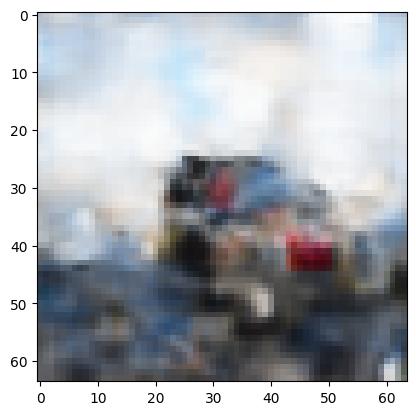

In [79]:
# encoding -= move_vector*3
sample_output = autoencoder.decoder(autoencoder.linear_before_decoder(encoding).view(1, 64, 8, 8))
#print((encoding - encoding2).pow(2).sum().sqrt())
plt.imshow(sample_output.detach().squeeze().permute(1,2,0))

tensor(0.) tensor(1.)
torch.Size([1, 3, 64, 64]) tensor(0.0026, grad_fn=<MseLossBackward0>)


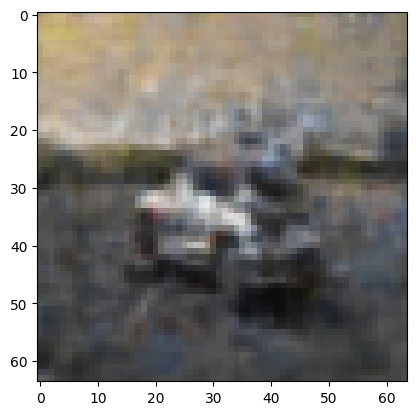

In [70]:
sample_input = next(iter(loader))[0]
print(sample_input.min(), sample_input.max())
sample_output = autoencoder(sample_input[0].unsqueeze(0))
print(sample_output.shape, mse(sample_output, sample_input[0].unsqueeze(0)))
plt.imshow(sample_output.detach().squeeze().permute(1,2,0))

In [89]:
losses = []
for epoch in range(100000):
    for batch_index, batch in enumerate(loader):
        moved = batch[0].to(DEVICE)

        output = autoencoder(moved)

        optimizer.zero_grad()
        loss = mse(output, moved)

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if len(losses) > 100:
            losses.pop(0)

        avg_loss = sum(losses) / len(losses)

        print(epoch, batch_index, avg_loss, loss.item(), "                                                                                                          ", end='\r')

KeyboardInterrupt: 

In [85]:
torch.save(autoencoder, './trained/autoencoder_two_dim_embedding_on_512_images.pth')

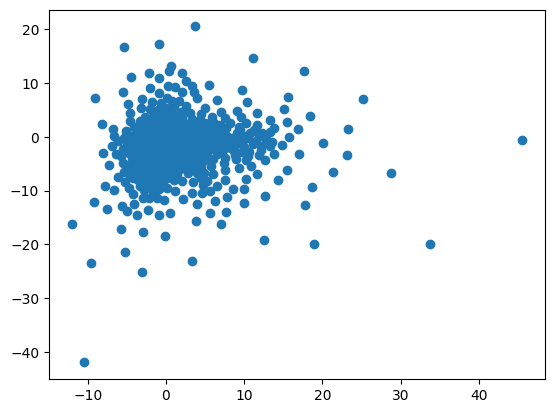

In [84]:
# plot distribution?

x = []
y = []

for i in range(len(dataset)):
    point = autoencoder.encoder(dataset[i][0].unsqueeze(0))[0]

    x.append(point[0].item())
    y.append(point[1].item())


plt.scatter(x, y)


In [14]:
SAMPLES = 16

In [11]:
from torchvision.transforms import transforms

In [12]:
import pickle

In [13]:
totensor = transforms.ToTensor()
toimage = transforms.ToPILImage()

In [15]:
# resize real samples
real = []

for i in range(SAMPLES**2):
    real_image = dataset[i][0]
    resized = totensor(toimage(real_image).resize((299,299)))
    real.append(resized)

print('done')
pickle.dump(real, open("./samples_for_fid/real_car_samples_autoencoder.pkl", 'wb'))

done


In [16]:
# generate fake samples

generated = []


x_range = 10 - -7
y_range = 10 - -10
x_step = x_range / SAMPLES
y_step = y_range / SAMPLES
x_start = -7
y_start = -10

for i in range(SAMPLES):
    for j in range(SAMPLES):
        a = i * x_step + x_start
        b = j * y_step + y_start

        latent_vector = torch.tensor([a, b]).unsqueeze(0)

        gened = autoencoder.decoder(autoencoder.linear_before_decoder(latent_vector).view(64, 8, 8))

        generated.append(totensor(toimage(gened).resize((299, 299))))
print('done')
pickle.dump(generated, open("./samples_for_fid/fake_car_samples_autoencoder.pkl", 'wb'))

done


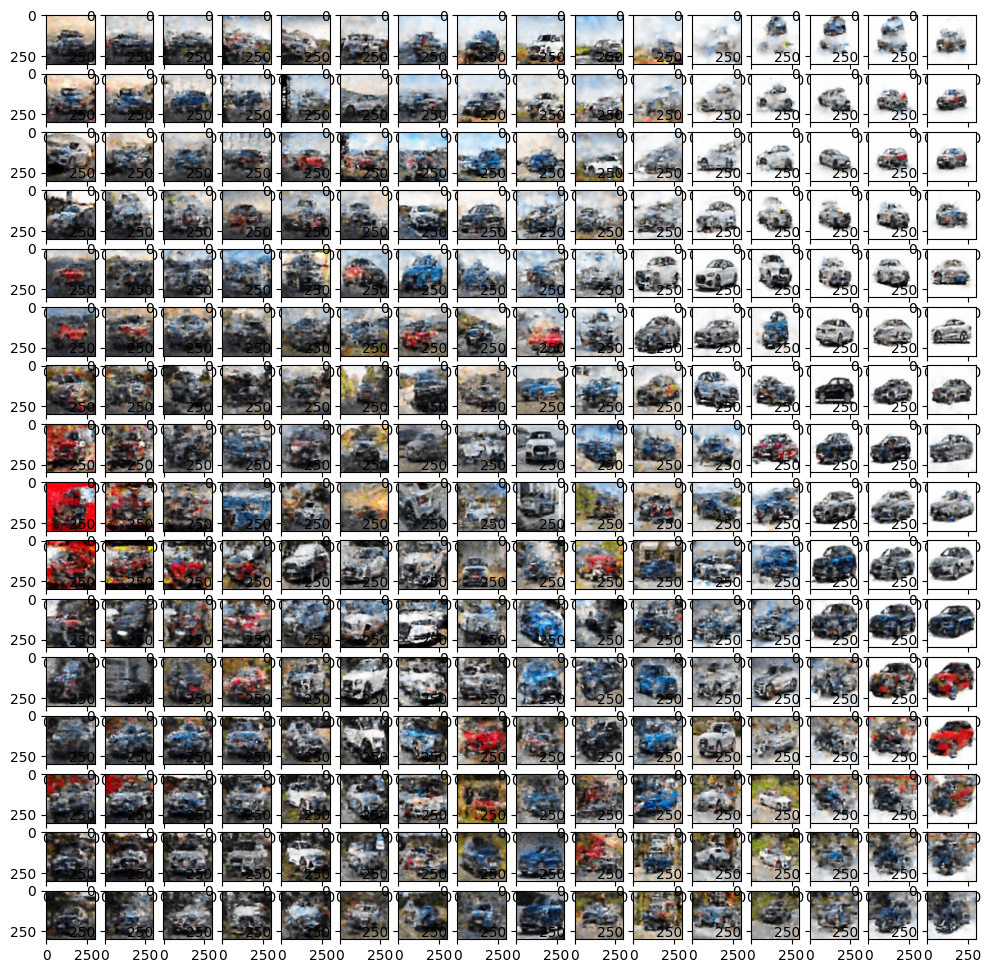

In [19]:
fig, axs = plt.subplots(16, 16, figsize=(12, 12))
for i in range(SAMPLES):
    for j in range(SAMPLES):
        axs[i][j].imshow(generated[i*16+j].detach().permute(1,2,0).numpy())